# Classification of Supernovae (SN Ia vs Non-SN Ia)

###  Imports

In [79]:

import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score
)
from catboost import CatBoostClassifier


### Generate matched redshift training data

In [80]:

def match_redshift_distribution(train_df, test_df, redshift_col='redshift', n_bins=20, total_train_samples=None, random_state=None):
    """
    Select a subset from train_df such that the redshift distribution matches that of test_df.

    Parameters:
        train_df (pd.DataFrame): Original training set with redshift column.
        test_df (pd.DataFrame): Test set with redshift column.
        redshift_col (str): Name of the redshift column.
        n_bins (int): Number of bins to use for distribution matching.
        total_train_samples (int or None): Total number of samples to draw from train_df.
        random_state (int or None): Seed for reproducibility.

    Returns:
        pd.DataFrame: Subset of train_df with matched redshift distribution.
    """
    bins = np.linspace(test_df[redshift_col].min(), test_df[redshift_col].max(), n_bins + 1)
    test_hist, _ = np.histogram(test_df[redshift_col], bins=bins)
    test_proportions = test_hist / test_hist.sum()

    if total_train_samples is None:
        total_train_samples = len(train_df)

    train_subset = pd.DataFrame()
    rng = np.random.default_rng(random_state)

    for i in range(n_bins):
        bin_mask = (train_df[redshift_col] >= bins[i]) & (train_df[redshift_col] < bins[i+1])
        bin_samples = train_df[bin_mask]

        n_to_sample = int(test_proportions[i] * total_train_samples)
        if len(bin_samples) > 0:
            sampled = bin_samples.sample(n=min(n_to_sample, len(bin_samples)), replace=False, random_state=random_state)
            train_subset = pd.concat([train_subset, sampled], ignore_index=True)

    return train_subset.sample(frac=1, random_state=random_state).reset_index(drop=True)

train_df=pd.read_csv('plasticc_train_data.csv')
test_df=pd.read_csv('des_test_data.csv') 
matched_train_df = match_redshift_distribution(
    train_df, test_df,
    redshift_col='photo_z',
    n_bins=20,
     
    random_state=42
)



print(f"Test set size: {len(test_df)}")
print(f"Matched training set size: {len(matched_train_df)}")


Test set size: 456
Matched training set size: 4376


###  Load and Inspect Data

In [81]:

# Load dataset
df_train = matched_train_df
df_test = pd.read_csv('des_test_data.csv')

# Show unique transient types
print("Printing Transient Types:", df_train['type'].unique())

# Group all non-SN Ia as 'Non-SNIa'
df_train.loc[df_train['type'] != 'SN Ia', 'type'] = 'Non-SNIa'
df_test.loc[df_test['type'] == 1, 'type'] = 'SN Ia'
df_test.loc[df_test['type'] != 'SN Ia', 'type'] = 'Non-SNIa'

Printing Transient Types: ['SN II' 'SN Ia' 'SN Ibc' 'SN Iax' 'SN Ia-91bg' 'TDE' 'CaRT' 'SLSN' 'ILOT'
 'Point source μ-lensing' 'PISN' 'Binary system μ-lensing']


###  Define Features and Labels

In [82]:

feature_cols = [
    'g_pk_mag','r_pk_mag', 'i_pk_mag', 'z_pk_mag', 
    'g_alpha', 'g_beta', 'r_alpha', 'r_beta', 'i_alpha', 'i_beta',
    'z_alpha', 'z_beta'
]
label_col = 'type'



###  Define Training, Validation and Test Set


In [83]:
x_train_val = df_train[feature_cols].to_numpy()
y_train_val = df_train[label_col].to_numpy()

x_test = df_test[feature_cols].to_numpy()
y_test = df_test[label_col].to_numpy()


x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.1, random_state=90
)

print('Training data size:', np.shape(x_train)[0])
print('Test data size:', np.shape(x_test)[0])
print('No. of features:', np.shape(x_train)[1])


Training data size: 3938
Test data size: 456
No. of features: 12


###  Train CatBoost with Multiple Seeds

In [84]:

as1_t, ps_t, re_t, f1_t = [], [], [], [] ##Training
as1_v, ps_v, re_v, f1_v = [], [], [], [] ##Validation
as1, ps, re, f1 = [], [], [], []        ##Test

random_seed_list = [20]

for seed in random_seed_list:
    clf = CatBoostClassifier(verbose=False, random_seed=seed)
    classifier = clf.fit(x_train, y_train, eval_set=(x_val, y_val))

    # Predictions
    y_pred_train = classifier.predict(x_train)
    y_pred_val = classifier.predict(x_val)
    y_pred_test = classifier.predict(x_test)

    # Train metrics
    as1_t.append(accuracy_score(y_train, y_pred_train))
    ps_t.append(precision_score(y_train, y_pred_train, pos_label='SN Ia'))
    re_t.append(recall_score(y_train, y_pred_train, pos_label='SN Ia'))
    f1_t.append(f1_score(y_train, y_pred_train, pos_label='SN Ia'))

    # Validation metrics
    as1_v.append(accuracy_score(y_val, y_pred_val))
    ps_v.append(precision_score(y_val, y_pred_val, pos_label='SN Ia'))
    re_v.append(recall_score(y_val, y_pred_val, pos_label='SN Ia'))
    f1_v.append(f1_score(y_val, y_pred_val, pos_label='SN Ia'))

    # Test metrics
    as1.append(accuracy_score(y_test, y_pred_test))
    ps.append(precision_score(y_test, y_pred_test, pos_label='SN Ia'))
    re.append(recall_score(y_test, y_pred_test, pos_label='SN Ia'))
    f1.append(f1_score(y_test, y_pred_test, pos_label='SN Ia'))


###  Print Metrics 

In [85]:

def fmt(x):
    return f"{np.mean(x)*100:.1f}% ± {np.std(x)*100:.1f}%"

metrics = {
    'Train': [as1_t, ps_t, re_t, f1_t],
    'Validation': [as1_v, ps_v, re_v, f1_v],
    'Test': [as1, ps, re, f1]
}

names = ['Accuracy', 'Precision', 'Recall', 'F1-score']

for split, vals in metrics.items():
    print(f"{split}: " + ", ".join(f"{n}: {fmt(v)}" for n, v in zip(names, vals)))


Train: Accuracy: 99.9% ± 0.0%, Precision: 100.0% ± 0.0%, Recall: 99.9% ± 0.0%, F1-score: 99.9% ± 0.0%
Validation: Accuracy: 97.0% ± 0.0%, Precision: 94.2% ± 0.0%, Recall: 97.3% ± 0.0%, F1-score: 95.7% ± 0.0%
Test: Accuracy: 90.1% ± 0.0%, Precision: 96.5% ± 0.0%, Recall: 89.9% ± 0.0%, F1-score: 93.1% ± 0.0%


###  Confusion Matrix (last run)

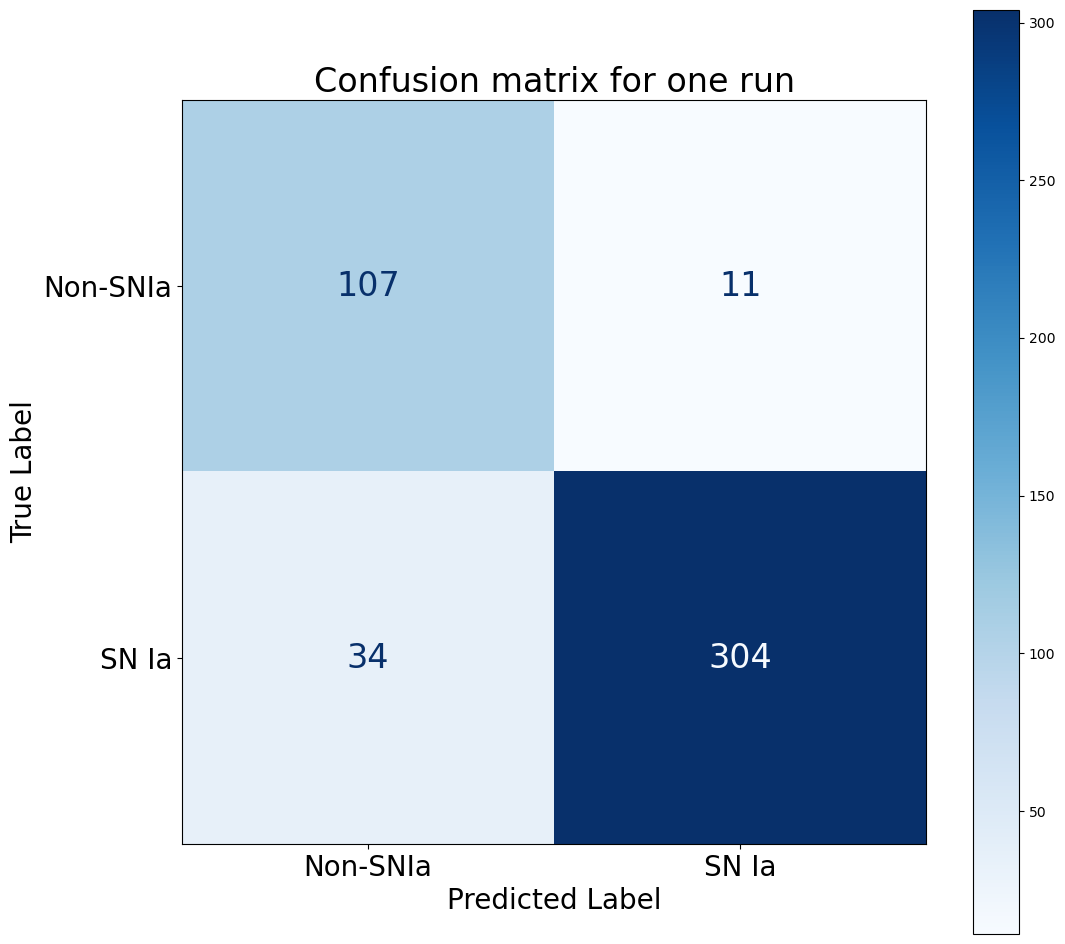

In [92]:

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap='Blues', values_format='d')

# Customize font sizes
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
for label in ax.texts:
    label.set_fontsize(24)

plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion matrix for one run', fontsize=24)
os.makedirs("Figures", exist_ok=True)
plt.savefig('Figures/Confusion_Matrix_Catboost_Matchedz.png')
plt.show()
